# Классификация возраста, пола и расы по лицу человека
---
Кабанов Евгений, РИМ-281226

Марго Бабайлова, РИМ-281226

<h2 style="color:#c2ba4a;">Внимание</h2>
<p style="color:#c2ba4a;">Данные, полученные в лабороторной являются неадекватными, тк из исходного набора данных использовалось только 30 фотографий и обучение длится 1 эпоху 
    <br /><b>Гипотетически</b>, все работает, для получения корректной работы необходимо предоставить полный набор данных и отрегулировать параметры ниже </p>

In [ ]:
NUMBER_OF_EPOCHS = 1

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [2]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (13,8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [41]:
from torch.utils import data
import re

resize_size = 224

T = transforms.Compose([
    transforms.Resize([resize_size,resize_size]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('/')[-1].split('_')[0])
        gender = int(ID.split('/')[-1].split('_')[1])
        race = int(ID.split('/')[-1].split('_')[2])
        
        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race
    
def plain_to_labels(age, gender, race):
    gender_dict = {0:"male", 1:"female"}
    race_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Not common race"}
    age_dict = {0:"0-5", 1:"5-14", 2:"14-30", 3:"30-45", 4:"45-60", 5:"60+"}
    
    # костыль tensor(%d) -> %d    
    age = int(re.findall(r"\d", str(age))[0])
    gender = int(re.findall(r"\d", str(gender))[0])
    race = int(re.findall(r"\d", str(race))[0])

    age = age_dict.get(age)
    gender = gender_dict.get(gender)
    race = race_dict.get(race)
    
    return age, gender, race

In [65]:
path_to_data = '/Users/spbravo/Downloads/UTKFace_mini'
# path_to_data = '/Users/spbravo/Downloads/UTKFace'
train_data = Dataset(path_to_data, subset='train', test_part = 0.2, transform = T)
valid_data = Dataset(path_to_data, subset='valid', test_part = 0.2, transform = T)

In [66]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  6
valid data len:  24


Ниже представлен пример получения изображения по индексу.

14-30
female
Indian


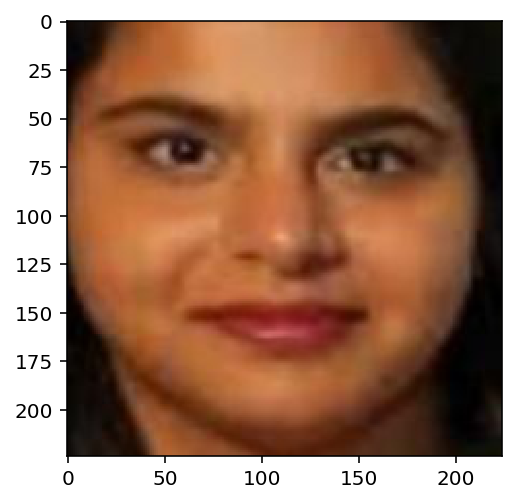

In [69]:
img, age, gender, race = train_data[0]
age, gender, race = plain_to_labels(age, gender, race)
print(age)
print(gender)
print(race)
plt.imshow(img.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [70]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

14-30 female Indian
14-30 female Indian
14-30 female Black
14-30 female Indian
14-30 female Black
14-30 female Indian


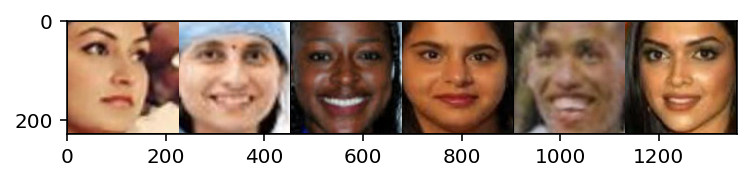

In [71]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

for i in range(len(age)):
    age_i, gender_i, race_i = plain_to_labels(age[i], gender[i], race[i])
    print(age_i, gender_i, race_i)

In [47]:
model_labels = ['resnet50', 'resnet34', 'mobilenetv2']
optimizer_labels = ['SGD', 'Adam']

epochs_count = NUMBER_OF_EPOCHS

predict_demo_packs_limit = 1

In [38]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            size = 1280 * 7 * 7
            self.model = models.mobilenet_v2(pretrained=True)
            self.model.classifier = nn.Dropout(p=0.2, inplace=False)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)
            # code here
        elif self.net == 'resnet34':
            size = 512
            self.model = models.resnet34(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)
            # code here
        elif self.net == 'resnet50':
            size = 2048
            self.model = models.resnet50(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)


    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x) # only dropout
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        
        return age, gender, race

# Model: resnet50

## Training with SGD optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 3.961, val_loss: 4.558 
 +                acc_age: 0.167, val_acc_age: 0.000 
  +                acc_gender: 0.333, val_acc_gender: 0.000 
  +                acc_race: 0.500, val_acc_race: 0.333


### Finished Training

### Preview results on first 16 images

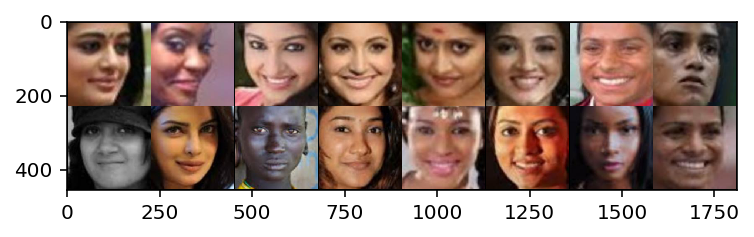

1 : 0-5 male Black
2 : 0-5 male Black
3 : 5-14 male White
4 : 5-14 male White
5 : 5-14 male Black
6 : 0-5 male White
7 : 0-5 male Black
8 : 5-14 male Black
9 : 5-14 male Asian
10 : 5-14 male Indian
11 : 0-5 male Black
12 : 45-60 male Indian
13 : 0-5 male White
14 : 5-14 male Asian
15 : 0-5 male Black
16 : 0-5 male White


## Training with Adam optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 3.953, val_loss: 2.624 
 +                acc_age: 0.167, val_acc_age: 1.000 
  +                acc_gender: 0.333, val_acc_gender: 1.000 
  +                acc_race: 0.500, val_acc_race: 0.292


### Finished Training

### Preview results on first 16 images

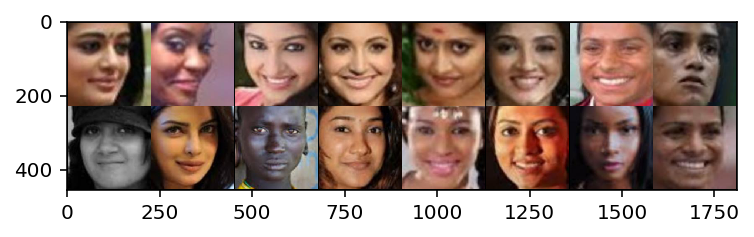

1 : 14-30 female Black
2 : 14-30 female Black
3 : 14-30 female Black
4 : 14-30 female Black
5 : 14-30 female Black
6 : 14-30 female Black
7 : 14-30 female Black
8 : 14-30 female Black
9 : 14-30 female Black
10 : 14-30 female Black
11 : 14-30 female Black
12 : 14-30 female Black
13 : 14-30 female Black
14 : 14-30 female Black
15 : 14-30 female Black
16 : 14-30 female Black


---

# Model: resnet34

## Training with SGD optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 5.034, val_loss: 4.927 
 +                acc_age: 0.000, val_acc_age: 0.000 
  +                acc_gender: 0.333, val_acc_gender: 0.708 
  +                acc_race: 0.000, val_acc_race: 0.000


### Finished Training

### Preview results on first 16 images

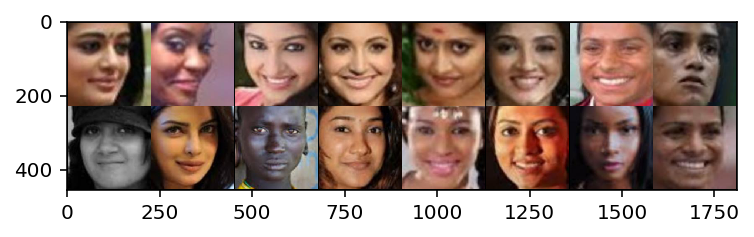

1 : 0-5 male Not common race
2 : 0-5 female White
3 : 5-14 female White
4 : 5-14 female White
5 : 5-14 female White
6 : 5-14 female White
7 : 0-5 female Not common race
8 : 0-5 female White
9 : 0-5 male Not common race
10 : 0-5 female Not common race
11 : 5-14 male Not common race
12 : 0-5 female Not common race
13 : 0-5 female White
14 : 0-5 male Not common race
15 : 5-14 male Not common race
16 : 0-5 female Black


## Training with Adam optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 5.017, val_loss: 4.404 
 +                acc_age: 0.000, val_acc_age: 0.083 
  +                acc_gender: 0.333, val_acc_gender: 0.000 
  +                acc_race: 0.000, val_acc_race: 0.625


### Finished Training

### Preview results on first 16 images

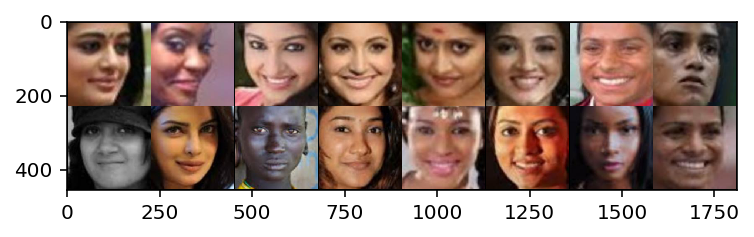

1 : 14-30 male Indian
2 : 0-5 male Not common race
3 : 0-5 male Indian
4 : 60+ male Indian
5 : 60+ male Indian
6 : 60+ male Indian
7 : 60+ male Indian
8 : 60+ male Indian
9 : 60+ male Indian
10 : 60+ male Indian
11 : 60+ male Indian
12 : 60+ male Indian
13 : 0-5 male Not common race
14 : 60+ male Indian
15 : 60+ male Indian
16 : 60+ male Not common race


---

# Model: mobilenetv2

## Training with SGD optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 3.725, val_loss: 3.289 
 +                acc_age: 0.500, val_acc_age: 0.458 
  +                acc_gender: 0.667, val_acc_gender: 1.000 
  +                acc_race: 0.333, val_acc_race: 0.417


### Finished Training

### Preview results on first 16 images

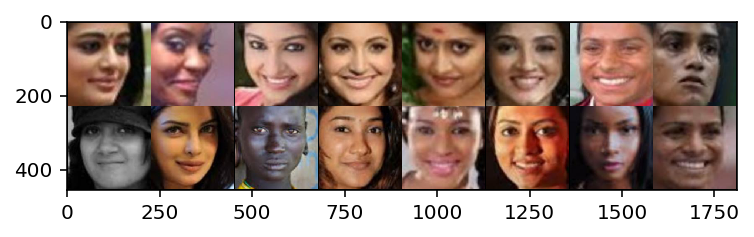

1 : 14-30 female Black
2 : 14-30 female Black
3 : 14-30 female Asian
4 : 0-5 female Black
5 : 5-14 female Black
6 : 0-5 female Asian
7 : 14-30 female Asian
8 : 14-30 female White
9 : 14-30 female Black
10 : 0-5 female Indian
11 : 14-30 female Black
12 : 5-14 female Black
13 : 14-30 female Black
14 : 0-5 female Black
15 : 0-5 female Asian
16 : 60+ female Indian


## Training with Adam optimizer

### Training start. Total number of epochs: 1

Epoch 1, loss: 3.540, val_loss: 6.132 
 +                acc_age: 0.333, val_acc_age: 1.000 
  +                acc_gender: 1.000, val_acc_gender: 1.000 
  +                acc_race: 0.500, val_acc_race: 0.708


### Finished Training

### Preview results on first 16 images

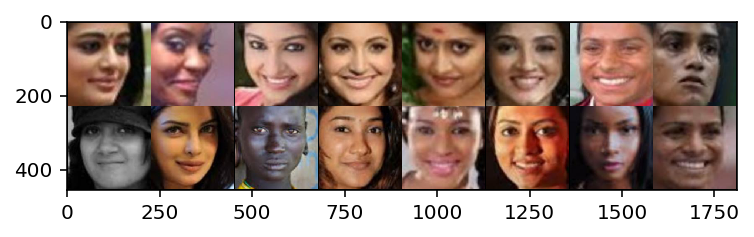

1 : 14-30 female Indian
2 : 14-30 female Indian
3 : 14-30 female Indian
4 : 14-30 female Indian
5 : 14-30 female Indian
6 : 14-30 female Indian
7 : 14-30 female Indian
8 : 14-30 female Indian
9 : 14-30 female Indian
10 : 14-30 female Indian
11 : 14-30 female Indian
12 : 14-30 female Indian
13 : 14-30 female Indian
14 : 14-30 female Indian
15 : 14-30 female Indian
16 : 14-30 female Indian


---

In [72]:
import torch.optim as optim
from IPython.display import clear_output
from IPython.display import display, Markdown

for model_name in model_labels:
    display(Markdown("# Model: " + str(model_name)))
    
    model = Net(net=model_name).to(device)
    
    for optimizer_name in optimizer_labels:
        
        display(Markdown("## Training with " + str(optimizer_name) + " optimizer"))

        criterion = nn.CrossEntropyLoss()
        
        if (optimizer_name == "SGD"):
            optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)
        
        if (optimizer_name == "Adam"):
            optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        

        display(Markdown("### Training start. Total number of epochs: " + str(epochs_count)))
        for epoch in range(epochs_count):  # loop over the dataset multiple times

            for phase in ['train', 'valid']:

                if phase == 'train':

                    model.train(True)

                    running_loss = 0.0
                    correct = 0
                    total = 0

                    age_correct = 0
                    gender_correct = 0
                    race_correct = 0

                    for i, data in enumerate(train_loader):
                        #  get the inputs; data is a list of [inputs, labels]
                        inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        out_age, out_gender, out_race = model(inputs)

                        loss_age = criterion(out_age, age)
                        loss_gender = criterion(out_gender, gender)
                        loss_race = criterion(out_race, race)

                        loss = loss_age + loss_gender + loss_race

                        loss.backward()
                        optimizer.step()

                        # print statistics
                        running_loss += loss.item()

                        _, age_pred = torch.max(out_age.data, 1)
                        _, gender_pred = torch.max(out_gender.data, 1)
                        _, race_pred = torch.max(out_race.data, 1)

                        total += gender.size(0)

                        age_correct += (age_pred == age).sum().item()
                        gender_correct += (gender_pred == gender).sum().item()
                        race_correct += (race_pred == race).sum().item()


                elif phase == 'valid':

                    model.train(False)

                    validation_loss = 0.0
                    v_correct = 0
                    v_total = 0

                    v_age_correct = 0
                    v_gender_correct = 0
                    v_race_correct = 0

                    for i, v_data in enumerate(valid_loader):
                        v_loss_age = 0
                        v_loss_gender = 0
                        v_loss_race = 0
                        v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                        v_out_age, v_out_gender, v_out_race = model(v_inputs)

                        v_loss_age += criterion(v_out_age, v_age)
                        v_loss_gender += criterion(v_out_gender, v_gender)
                        v_loss_race += criterion(v_out_race, v_race)

                        validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                        _, v_age_pred = torch.max(v_out_age.data, 1)
                        _, v_gender_pred = torch.max(v_out_gender.data, 1)
                        _, v_race_pred = torch.max(v_out_race.data, 1)

                        v_total += v_gender.size(0)

                        v_age_correct += (v_age_pred == v_age).sum().item()
                        v_gender_correct += (v_gender_pred == v_gender).sum().item()
                        v_race_correct += (v_race_pred == v_race).sum().item()


            print('Epoch %d, loss: %.3f, val_loss: %.3f \n +\
                acc_age: %.3f, val_acc_age: %.3f \n  +\
                acc_gender: %.3f, val_acc_gender: %.3f \n  +\
                acc_race: %.3f, val_acc_race: %.3f' %
                  (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
                    age_correct / total, v_age_correct / v_total,
                    gender_correct / total, v_gender_correct / v_total,
                    race_correct / total, v_race_correct / v_total,
                  ))        

        display(Markdown("### Finished Training"))

        display(Markdown("### Preview results on first " + str(predict_demo_packs_limit * 16) + " images"))

        for i in range(predict_demo_packs_limit):
            _, data = next(enumerate(valid_loader))

    #     for i, data in enumerate(valid_loader):
            inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

            plt.imshow(torchvision.utils.make_grid(inputs).numpy().transpose(1,2,0))
            plt.show()

            out_age, out_gender, out_race = model(inputs)

            _, age_pred = torch.max(out_age.data, 1)
            _, gender_pred = torch.max(out_gender.data, 1)
            _, race_pred = torch.max(out_race.data, 1)

            for i in range(len(age_pred)):
                age_pred_i, gender_pred_i, race_pred_i = plain_to_labels(age_pred[i], gender_pred[i], race_pred[i])
                print(i+1, ":", age_pred_i, gender_pred_i, race_pred_i)
            
    display(Markdown("---"))